### Scene modeling photometry examples

This notebook will demonstrate a few use cases for the SMP software. We are only providing a very small subset of the full set of photometric measurements from DES (as there would be too many files otherwise).

The software assumes that the images have already been trimmed to (consistent) postage stamp sizes.  

In addition to the stamps, we will also need a table of zeropoints from DES and the PSF files for each image. These are provided in the `data` directory.

First, a few imports

In [1]:
#general
import numpy as np 
import matplotlib.pyplot as pl
import pickle

#des specific
import destnosim

#smp
import smp

#### Simple case: high-$S/N$ source with no background
Let's start with a simple example of a $Y$ band exposure from the large TNO Eris. The information was taken from the photometry table provided in ()[].

In [2]:
eris = smp.Detection(ra =25.62472153, dec = -3.41797168, band = 'Y', expnum = 234928, ccdnum = 20, name='eris') #name defined for file handling purposes

Procedurally, all we need to do is call the `Detection.runPhotometry` method - this convenience function implements all the steps needed for the SMP to work. Under the hood, this function runs the following methods, with some simple descriptions of the basic usage:

- `Detection.findAllExposures(survey)`: finds all overlapping exposure in the survey (uses `destnosim` `survey` object)

- `ra_grid, dec_grid = local_grid(Detection.ra, Detection.dec, spacing, n_grid,)`: constructs the grid of background point sources, with $n_\mathrm{grid} \times n_\mathrm{grid}$ sources spread every `spacing` degrees

- `Detection.constructImages(zeropoints, stamps_path)`: constructs the image matrix, where each entry corresponds to a pixel $(i,j)$ in exposure $\mu$, $\mathbf{Im}_{ij}^\mu$. In this step, the images are also scaled to a common zeropoint ($=30$), and some optional background subtraction can be applied (not the case in the DES data release)

- `Detection.constructPSFs(ra_grid, dec_grid, pixelmapcollection, size, offset_x, offset_y, piff_path)`: constructs the point source array for each background source in each image, as well as the point source for the target (with a potential for a pixel offset given by `offset_x` and `offset_y`). This requires the astrometric solutions from `pixmappy`

- `Detection.constructDesignMatrix(size)`: constructs the design matrix for the linear system

- `Detection.solvePhotometry()`: solves the linear system, also producing the residuals and error estimates

This implementation uses sparce matrices from `scipy.sparse` to reduce memory usage.

Let's first load the survey information and the zeropoint dictionary:

In [11]:
desy6 = destnosim.DES('y6a1c') ## see the destnosim documentation for an explanation
desy6.createExposures()

# zeropoints
with open('data/zeropoints.pkl', 'rb') as f:
    zeropoints = pickle.load(f)

In [4]:
eris.runPhotometry(se_path = 'data/stamps/eris/', piff_path='data/psfs/',
                	zp = zeropoints, survey = desy6, sparse = True, offset_x=-1, offset_y=-1,) 

/usr/local/lib/python3.10/dist-packages/galsim/deprecated/__init__.py:48: GalSimDeprecationWarning: tol has been deprecated since GalSim version 2.2.  Use gsparams=GSParams(kvalue_accuracy=tol) instead.
  warnings.warn(s, GalSimDeprecationWarning)


PSF matrix
Background
Design
Product
Solving
Solved


As simple as that - now let's visualize the outputs. First the fluxes, and then the 5 panel stamps as in Figure 1 of [Bernardinelli et al (2023)](https://arxiv.org/abs/2304.03017).

In [5]:
print(f'Flux: {eris.flux:.5f}, flux uncertainty: {eris.sigma_flux:.5f}')
print(f'Magnitude: {eris.mag:.5f}, flux uncertainty: {eris.sigma_mag:.5f}')

Flux: 37942.36311, flux uncertainty: 924.96595
Magnitude: 18.55219, flux uncertainty: 0.02647


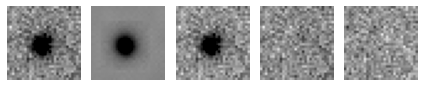

In [14]:
from image_tools import clippedMean #clipped mean to define limits in image visualization

# these are 30x30 stamps, and the code always saves the target image as the last in the array, so we can access it easily:
image = eris.image[-900:].reshape((30,30)) 
model = eris.pred[-900:].reshape((30,30))
residual = eris.res[-900:].reshape((30,30))
source = (eris.flux * eris.psf_source).reshape((30,30))

sigma = np.sqrt(clippedMean(image, 4)[1])
# let's make a 1x5 subplot, same as the examples in the paper - see `smp_utils.make_mugshots_fivepanel` for an automated way of making several of these in the same format as the paper


pl.subplot(1,5,1)
pl.imshow(image, vmin=-3*sigma, vmax=4*sigma, cmap='gray_r', origin='lower')
pl.axis('off')

pl.subplot(1,5,2)
pl.imshow(model, vmin=-3*sigma, vmax=4*sigma, cmap='gray_r', origin='lower')
pl.axis('off')

pl.subplot(1,5,3)
#this is equivalent to subtracting only the background part of the model from the image
pl.imshow(image - model + source, vmin=-3*sigma, vmax=4*sigma, cmap='gray_r', origin='lower')
pl.axis('off')

pl.subplot(1,5,4)
#this is equivalent to subtracting only the target source from the image
pl.imshow(image - source, vmin=-3*sigma, vmax=4*sigma, cmap='gray_r', origin='lower')
pl.axis('off')


pl.subplot(1,5,5)
pl.imshow(residual, vmin=-3*sigma, vmax=4*sigma, cmap='gray_r', origin='lower')
pl.axis('off')
pl.tight_layout()

pl.show()


#### More complicated case: high-$S/N$ source with significant blending

Now, towards a more complicated case, with significant blending between the source and background. This is an $i$ band detection of 2014 $\text{VV}_{39}$.

In [7]:
vv = smp.Detection(ra =11.438342, dec = 3.4346353, band = 'i', expnum = 572637, ccdnum = 9, name='2014vv39') #name defined for file handling purposes

Same procedure as before:

In [8]:
vv.runPhotometry(se_path = 'data/stamps/2014vv39/', piff_path='data/psfs/',zp = zeropoints, survey = desy6, sparse = True, offset_x=-1, offset_y=-1,) 

/home/pedro/Dropbox/DES/SceneModelingPhotometry/smp.py:254: RuntimeWarning: divide by zero encountered in divide
  self.invwgt = 1/self.wgt
/usr/local/lib/python3.10/dist-packages/galsim/deprecated/__init__.py:48: GalSimDeprecationWarning: tol has been deprecated since GalSim version 2.2.  Use gsparams=GSParams(kvalue_accuracy=tol) instead.
  warnings.warn(s, GalSimDeprecationWarning)


PSF matrix
Background
Design
Product
Solving
Solved


The runtime, on my local machine, went from 29 seconds for the Eris example to 46 seconds for this VV detection. The dominating factor is that there are more stamps and PSFs to be loaded of this VV detection than of the Eris detection. 

Let's see the fluxes and visualize the stamps, same as before:

In [12]:
print(f'Flux: {vv.flux:.5f}, flux uncertainty: {vv.sigma_flux:.5f}')
print(f'Magnitude: {vv.mag:.5f}, flux uncertainty: {vv.sigma_mag:.5f}')

Flux: 930.02571, flux uncertainty: 76.99258
Magnitude: 22.57876, flux uncertainty: 0.08988


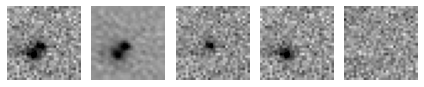

In [13]:
# these are 30x30 stamps, and the code always saves the target image as the last in the array, so we can access it easily:
image = vv.image[-900:].reshape((30,30)) 
model = vv.pred[-900:].reshape((30,30))
residual = vv.res[-900:].reshape((30,30))
source = (vv.flux * vv.psf_source).reshape((30,30))

sigma = np.sqrt(clippedMean(image, 4)[1])
# let's make a 1x5 subplot, same as the examples in the paper - see `smp_utils.make_mugshots_fivepanel` for an automated way of making several of these in the same format as the paper


pl.subplot(1,5,1)
pl.imshow(image, vmin=-3*sigma, vmax=4*sigma, cmap='gray_r', origin='lower')
pl.axis('off')

pl.subplot(1,5,2)
pl.imshow(model, vmin=-3*sigma, vmax=4*sigma, cmap='gray_r', origin='lower')
pl.axis('off')

pl.subplot(1,5,3)
#this is equivalent to subtracting only the background part of the model from the image
pl.imshow(image - model + source, vmin=-3*sigma, vmax=4*sigma, cmap='gray_r', origin='lower')
pl.axis('off')

pl.subplot(1,5,4)
#this is equivalent to subtracting only the target source from the image
pl.imshow(image - source, vmin=-3*sigma, vmax=4*sigma, cmap='gray_r', origin='lower')
pl.axis('off')


pl.subplot(1,5,5)
pl.imshow(residual, vmin=-3*sigma, vmax=4*sigma, cmap='gray_r', origin='lower')
pl.axis('off')

pl.tight_layout()
pl.show()


From the sets of stamps above, it's clear that this detection is heavily blended with the background galaxy, that virtually disappears in the background subtracted stamp. 

#### Binary scene modeling

As our final example, let's show what happens in the case of a binary TNO instead of a single point source. We'll use a resolved, high-$S/N$ $r$ band image of 2014 $\text{LQ}_{28}$ for this example.

First, a single PSF fit:

In [20]:
lq_single = smp.Detection(ra =356.18539123, dec = -0.620161911, band = 'r', expnum = 696265, ccdnum = 32, name='2014lq28')
lq_single.runPhotometry(se_path = 'data/stamps/2014lq28/', piff_path='data/psfs/',zp = zeropoints, survey = desy6, sparse = True, offset_x=-1, offset_y=-1,) 

/home/pedro/Dropbox/DES/SceneModelingPhotometry/smp.py:244: RuntimeWarning: divide by zero encountered in divide
  w = zero**2/image['WGT'].data.flatten()
/home/pedro/Dropbox/DES/SceneModelingPhotometry/smp.py:254: RuntimeWarning: divide by zero encountered in divide
  self.invwgt = 1/self.wgt
/usr/local/lib/python3.10/dist-packages/galsim/deprecated/__init__.py:48: GalSimDeprecationWarning: tol has been deprecated since GalSim version 2.2.  Use gsparams=GSParams(kvalue_accuracy=tol) instead.
  warnings.warn(s, GalSimDeprecationWarning)


PSF matrix
Background
Design
Product
Solving
Solved


Runtime is just under a minute - there are 11 total images (background + target) vs 6 for Eris and 8 for VV.

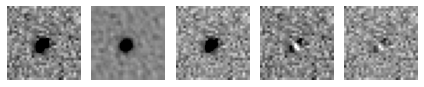

In [17]:
# these are 30x30 stamps, and the code always saves the target image as the last in the array, so we can access it easily:
image = lq_single.image[-900:].reshape((30,30)) 
model = lq_single.pred[-900:].reshape((30,30))
residual = image - model
source = (lq_single.flux * lq_single.psf_source).reshape((30,30))

sigma = np.sqrt(clippedMean(image, 4)[1])
# let's make a 1x5 subplot, same as the examples in the paper - see `smp_utils.make_mugshots_fivepanel` for an automated way of making several of these in the same format as the paper


pl.subplot(1,5,1)
pl.imshow(image, vmin=-3*sigma, vmax=4*sigma, cmap='gray_r', origin='lower')
pl.axis('off')

pl.subplot(1,5,2)
pl.imshow(model, vmin=-3*sigma, vmax=4*sigma, cmap='gray_r', origin='lower')
pl.axis('off')

pl.subplot(1,5,3)
#this is equivalent to subtracting only the background part of the model from the image
pl.imshow(image - model + source, vmin=-3*sigma, vmax=4*sigma, cmap='gray_r', origin='lower')
pl.axis('off')

pl.subplot(1,5,4)
#this is equivalent to subtracting only the target source from the image
pl.imshow(image - source, vmin=-3*sigma, vmax=4*sigma, cmap='gray_r', origin='lower')
pl.axis('off')


pl.subplot(1,5,5)
pl.imshow(residual, vmin=-3*sigma, vmax=4*sigma, cmap='gray_r', origin='lower')
pl.axis('off')

pl.tight_layout()
pl.show()


There's a very clear dipole in the residuals - this is an indication (but not confirmation) of a binary source.

Let's use the binary SMP fitter. It works the same as before, but now we can also specify a position offset for the secondary source (`shift_x/y_binary`):

In [21]:
lq_binary = smp.BinaryDetection(ra =356.18539123, dec = -0.620161911, band = 'r', expnum = 696265, ccdnum = 32, name='2014lq28')
lq_binary.runPhotometry(se_path = 'data/stamps/2014lq28/', piff_path='data/psfs/',zp = zeropoints, survey = desy6, sparse = True, \
                        offset_x=-1, offset_y=-1,shift_x_binary = 0, shift_y_binary = 0,) 

/home/pedro/Dropbox/DES/SceneModelingPhotometry/smp.py:244: RuntimeWarning: divide by zero encountered in divide
  w = zero**2/image['WGT'].data.flatten()
/home/pedro/Dropbox/DES/SceneModelingPhotometry/smp.py:254: RuntimeWarning: divide by zero encountered in divide
  self.invwgt = 1/self.wgt
/usr/local/lib/python3.10/dist-packages/galsim/deprecated/__init__.py:48: GalSimDeprecationWarning: tol has been deprecated since GalSim version 2.2.  Use gsparams=GSParams(kvalue_accuracy=tol) instead.
  warnings.warn(s, GalSimDeprecationWarning)


PSF matrix
Background
Design
Product
Solving
Solved


Note that the runtime is virtually the same as in the single PSF case: the binary change, with a fixed position pair, only adds an extra parameter in the model

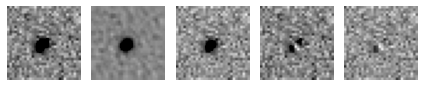

In [23]:
# these are 30x30 stamps, and the code always saves the target image as the last in the array, so we can access it easily:
image = lq_binary.image[-900:].reshape((30,30)) 
model = lq_binary.pred[-900:].reshape((30,30))
residual = image - model
source = (lq_binary.flux * lq_binary.psf_source).reshape((30,30))

sigma = np.sqrt(clippedMean(image, 4)[1])
# let's make a 1x5 subplot, same as the examples in the paper - see `smp_utils.make_mugshots_fivepanel` for an automated way of making several of these in the same format as the paper


pl.subplot(1,5,1)
pl.imshow(image, vmin=-3*sigma, vmax=4*sigma, cmap='gray_r', origin='lower')
pl.axis('off')

pl.subplot(1,5,2)
pl.imshow(model, vmin=-3*sigma, vmax=4*sigma, cmap='gray_r', origin='lower')
pl.axis('off')

pl.subplot(1,5,3)
#this is equivalent to subtracting only the background part of the model from the image
pl.imshow(image - model + source, vmin=-3*sigma, vmax=4*sigma, cmap='gray_r', origin='lower')
pl.axis('off')

pl.subplot(1,5,4)
#this is equivalent to subtracting only the target source from the image
pl.imshow(image - source, vmin=-3*sigma, vmax=4*sigma, cmap='gray_r', origin='lower')
pl.axis('off')


pl.subplot(1,5,5)
pl.imshow(residual, vmin=-3*sigma, vmax=4*sigma, cmap='gray_r', origin='lower')
pl.axis('off')

pl.tight_layout()
pl.show()


The dipole structure changed, but it's not ideal. The ideal situation requires minimizing the $\chi^2$ of the model (Equation 3 of [Bernardinelli et al 2023](https://arxiv.org/abs/2304.03017))

To do so, we need to specify a set of initial conditions, and the fitter will find the ideal position shifts $(\Delta x_0, \Delta x_1,\Delta  y_0,\Delta y_1)$.

In [25]:
%%capture
## above is an ipython magic command that will suppress the print calls inside the code
# nothing special is being printed (only the series of prints showed above for each new set of positions)
lq_binary.minimizeChisq(x_init=(-1,0,-1,0))

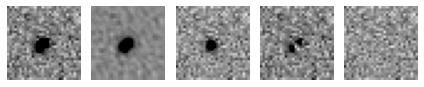

In [26]:
# these are 30x30 stamps, and the code always saves the target image as the last in the array, so we can access it easily:
image = lq_binary.image[-900:].reshape((30,30)) 
model = lq_binary.pred[-900:].reshape((30,30))
residual = image - model
source = (lq_binary.flux * lq_binary.psf_source).reshape((30,30))

sigma = np.sqrt(clippedMean(image, 4)[1])
# let's make a 1x5 subplot, same as the examples in the paper - see `smp_utils.make_mugshots_fivepanel` for an automated way of making several of these in the same format as the paper


pl.subplot(1,5,1)
pl.imshow(image, vmin=-3*sigma, vmax=4*sigma, cmap='gray_r', origin='lower')
pl.axis('off')

pl.subplot(1,5,2)
pl.imshow(model, vmin=-3*sigma, vmax=4*sigma, cmap='gray_r', origin='lower')
pl.axis('off')

pl.subplot(1,5,3)
#this is equivalent to subtracting only the background part of the model from the image
pl.imshow(image - model + source, vmin=-3*sigma, vmax=4*sigma, cmap='gray_r', origin='lower')
pl.axis('off')

pl.subplot(1,5,4)
#this is equivalent to subtracting only the target source from the image
pl.imshow(image - source, vmin=-3*sigma, vmax=4*sigma, cmap='gray_r', origin='lower')
pl.axis('off')


pl.subplot(1,5,5)
pl.imshow(residual, vmin=-3*sigma, vmax=4*sigma, cmap='gray_r', origin='lower')
pl.axis('off')

pl.tight_layout()
pl.show()


The structure in the residuals are essentially gone - meaning that we found an optimal solution.

Let's take a look into a few quantities of interest: the $\Delta \chi^2$, the fluxes of the two sources, and their separation

In [30]:
# Detection.res is equivalent to the image-model quantity above, and Detection.invwgt has the inverse uncertainties on each point
chi2_single = np.sum(lq_single.res * lq_single.res * lq_single.invwgt)
chi2_binary = np.sum(lq_binary.res * lq_binary.res * lq_binary.invwgt)

print(chi2_single - chi2_binary)

130.060224609957


The $\Delta \chi^2$ of 130 is a very strong indication that the 2-PSF model is better than the single PSF model

In [31]:
print(f'Flux primary: {lq_binary.flux_primary:.5f}, uncertainty: {lq_binary.sigma_flux_primary:.5f}')
print(f'Magnitude primary: {lq_binary.mag_primary:.5f}, uncertainty: {lq_binary.sigma_mag_primary:.5f}')

print(f'Flux primary: {lq_binary.flux_secondary:.5f}, uncertainty: {lq_binary.sigma_flux_secondary:.5f}')
print(f'Magnitude secondary: {lq_binary.mag_secondary:.5f}, uncertainty: {lq_binary.sigma_mag_secondary:.5f}')

Flux primary: 1322.43381, uncertainty: 60.66538
Magnitude primary: 22.19657, uncertainty: 0.04981
Flux primary: 943.02591, uncertainty: 60.57551
Magnitude secondary: 22.56369, uncertainty: 0.06974


So a difference of roughly 0.36 magnitudes between the sources. 

Finally, their separation:

In [35]:
x_sol = lq_binary.solution.x #the BinaryDetection.solution member is a scipy least_squares solution object
print(f'Position shifts: {x_sol}')
sep = np.sqrt((x_sol[0] - x_sol[1])**2 + (x_sol[2] - x_sol[3])**2)
print(f'Corresponding to {sep:.3f} pixels and {0.263*sep:.3f} arcseconds')

Position shifts: [-1.83705015  0.16574665 -1.62924359  0.20818431]
Corresponding to 2.718 pixels and 0.715 arcseconds
